<a href="https://colab.research.google.com/github/ftorres-10cero/Google-Colab-IA-Pix2Pix/blob/dev/IA_Notebook_Pix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial Dot CSV Pix2Pix con TensorFlow 2.0



# Introducción Pix2Pix

* Tutorial de DotCSV: https://www.youtube.com/watch?v=YsrMGcgfETY
* Paper: https://arxiv.org/pdf/1611.07004.pdf
* Doc: https://www.tensorflow.org/tutorials/generative/pix2pix


# Importación de dependencias y configuración del entorno

https://www.youtube.com/watch?v=YsrMGcgfETY&t=1572s

In [1]:
# Activamos la versión de tensorflow que vamos a usar: 2.0
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [19]:
# Realizamos las importaciones de librerias y declaramos las variables a usar

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


PATH = "/content/drive/My Drive/pix2pix"

# Ruta de datos de entrada
INPATH = PATH + '/in2'
# Ruta de datos de salida
OUTPATH = PATH + '/out'
# RUTA de los checkpoints
CKPATH = PATH + '/checkpoints'

imgurls = !ls -1 "{INPATH}"

n = 1000
train_n = round(n * 0.20)
test_n = round(n * 0.80)

# Listado randomizado
randurls = np.copy(imgurls)

np.random.seed(23)
np.random.shuffle(randurls)

# Partición train/test

tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print(len(imgurls), len(tr_urls), len(ts_urls))

6582 200 800


In [0]:
# Declaramos las constantes que vamos a usar y definimos las funciones básicas

IMG_WIDTH = 256
IMG_HEIGHT = 256

# Reescalar imágenes
def resize(inimg, tgimg, height, width):

  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])

  return inimg, tgimg

# Normaliza el rango [-1, +1] la imagen
def normalize(inimg, tgimg):
  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1

  return inimg, tgimg

# Aumentacion de datos : Rasdom Crop + Flip
def random_jitter(inimg, tgimg):

  inimg, tgimg = resize(inimg, tgimg, 286, 286)

  stacked_image = tf.stack([inimg, tgimg], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH,3])

  inimg, tgimg = cropped_image[0], cropped_image[1]

  if tf.random.uniform(()) > 0.5:

    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)

  return inimg, tgimg  

# Carga de imagenes
def load_image(filename, augment=False):

  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)[..., :3]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + '/' + filename)), tf.float32)[..., :3]  

  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)

  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)

  inimg, tgimg = normalize(inimg, tgimg)

  return inimg, tgimg


def load_train_image(filename):
  return load_image(filename, True)

def load_test_image(filename):
  return load_image(filename, False)

# Vemos la primera imagen del listado para ver que todo va bien
## plt.imshow(load_train_image(randurls[0])[0]+1/2)

In [0]:
# Cargamos los dataset con los listados de imágenes de entrenamiento y test

train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

# Visualización de lotes de imágenes
# for inimg, tgimg in train_dataset.take(5):
#   print(tgimg.shape)
#   plt.imshow(((tgimg[0,...])+1)/2)
#  plt.show()

test_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls =tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)


# Funciones de capas en el modelo Pix2Pix

https://www.youtube.com/watch?v=YsrMGcgfETY&t=2680s

In [0]:
# DISEÑO PIX2PIX


from tensorflow.keras import *
from tensorflow.keras.layers import *

In [0]:
def downsample(filters, apply_batchnorm=True):

  result = Sequential()

  initializer = tf.random_normal_initializer(0,0.1)

  # Capa convolacional
  result.add(Conv2D(filters,
                    kernel_size = 4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm))

  if apply_batchnorm:
    # Capa de BatchNorm
    result.add(BatchNormalization())

  # Capa de activación LeackyReLU
  result.add(LeakyReLU())

  return result

## downsample(64)  
 

In [0]:
def upsample(filters, apply_dropout=False):

  result = Sequential()

  initializer = tf.random_normal_initializer(0,0.1)

  # Capa convolacional
  result.add(Conv2DTranspose(filters,
                    kernel_size = 4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=False))

  #Capa de BatchNorm.
  result.add(BatchNormalization())
  
  if apply_dropout:
    # Capa de Dropout
    result.add(Dropout(0.5))

  # Capa de activación LeackyReLU
  result.add(ReLU())

  return result

## upsample(64) 

# Estructura del modelo Pix2Pix

Estructura de red:

* Encoder: C64-C128-C256-C512-C512-C512-C512
* Decoder: CD512-CD512-CD512-C512-C256-C128-C64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


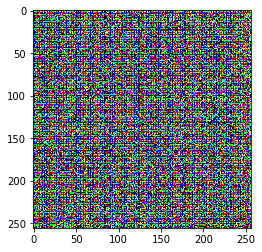

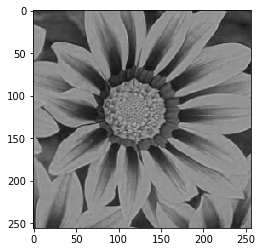

In [8]:
# Definión de la estructura U-net

def Generator():

  inputs = tf.keras.layers.Input(shape=[None,None,3])

  # Definimos las capas del Encoder
  down_stack = [
     downsample(64, apply_batchnorm=False),   # (bs, 128, 128, 64)
     downsample(128),                         # (bs, 64, 64, 128)
     downsample(256),                         # (bs, 32, 32, 256)
     downsample(512),                         # (bs, 16, 16, 512)
     downsample(512),                         # (bs, 8, 8, 512)
     downsample(512),                         # (bs, 4, 4, 512)
     downsample(512),                         # (bs, 2, 2, 512)
     downsample(512),                         # (bs, 1, 1, 512)
  ]

  # Definimos las capas del Decoder
  up_stack = [
     upsample(512, apply_dropout=True),       # (bs, 2, 2, 1024)
     upsample(512, apply_dropout=True),       # (bs, 4, 4, 1024)
     upsample(512, apply_dropout=True),       # (bs, 8, 8, 1024)
     upsample(512),                           # (bs, 16, 16, 1024)
     upsample(256),                           # (bs, 32, 32, 512)
     upsample(128),                           # (bs, 64, 64, 256)
     upsample(64),                            # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0, 0.1)

  last = Conv2DTranspose(filters =3,
                         kernel_size = 4,
                         strides = 2,
                         padding = "same",
                         kernel_initializer = initializer,
                         activation = "tanh")
  
  # Conectamos todas las capas

  # Estructura Hourglass

  ##  x = inputs

  ##  for down in down_stack:
  ##    x = down(x)

  ##  for up in up_stack:
  ##    x = up(x)

  ##  return last(x)  


  # Estructura U-net (con skip connections)

  x = inputs
  s = []
  concat = Concatenate()

  for down in down_stack:
    x = down(x)
    s.append(x)   # Almacenamos los resultados de cada capa

  s = reversed(s[:-1])  # Invertimos la lista de resultados

  for up, sk in zip(up_stack,s): # Ultilizamos una cremallera para extraer ambos elementos en paralelo
    x = up(x)
    x = concat([x,sk])

  last = last(x)  

  return Model(inputs=inputs, outputs=last)

generator = Generator()

## Probamos el generador
for inimg, tgimg in train_dataset.take(1):
#  plt.imshow(((inimg[0,...])+1)/2)
#  plt.show()
#  plt.imshow(((tgimg[0,...])+1)/2)
#  plt.show()
  gen_output = generator(inimg, training=False)
  plt.imshow(((gen_output[0,...])))
  plt.show()
  plt.imshow(((inimg[0,...])+1)/2)
  plt.show()


# Configuración PatchGan

* https://www.youtube.com/watch?v=YsrMGcgfETY?t=4364  1:12:44


In [0]:
# Definión del discriminador

def Discriminator():

  ini = Input(shape=[None, None,3], name="input_img")
  gen = Input(shape=[None, None,3], name="gener_img")

  con = concatenate([ini, gen])

  initializer = tf.random_normal_initializer(0, 0.1)

  down1 = downsample(64, apply_batchnorm=False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(128)(down2)
#  down4 = downsample(128)(down3)
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)

  conv = tf.keras.layers.Conv2D(filters =1,
                         kernel_size = 4,
                         strides = 1,
                         padding = "same",
                         kernel_initializer = initializer)(zero_pad1)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)

  return tf.keras.Model(inputs=[ini,gen], outputs=last)

discriminator = Discriminator()  

## Probamos el disriminador
## disc_out = discriminator([((inimg+1)*255), gen_output], training=False)
## ply.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
## plt.colorbar()
## disc_out.shapek


# Definición de función de Coste Adversaria
* https://www.youtube.com/watch?v=YsrMGcgfETY?t=4814s 1:20:22

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):

  # Diferencia entre los true por ser real y el detectado por el discriminador.
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  # Diferencia entre los false por ser generado y el detectado por el discriminador.
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [0]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):

  # Error adversario

  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Error absoluto

  l1_loss = tf.reduce_mean(tf.abs(target - gen_output)) # cálculo de media del absoluto de la diferencia

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss


In [0]:
# Guardamos los checkpoints (estados de aprendizaje)

import os

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_prefix = os.path.join(CKPATH, "ckpt")

# Guardamos los estados de nuestros aprendizajes
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Con la siguiente línea podemos rescatar el último checkpoint almacenado
checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

In [0]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):

  prediction = model(test_input, training=True)

  if save_filename:
    tf.keras.preprocessing.image.save_img(CKPATH + '/' + save_filename + '.jpg', prediction[0,...])

  plt.figure(figsize=(10,10))

  display_list = [test_input[0], prediction[0], tar[0]]
  title = ['Imagen de entrada', 'Imagen generada', 'Imagen esperada']

  if display_imgs:
      for i in range(3):
          plt.subplot(1, 3, i+1)
          plt.title(title[i])

          #getting the pixel values between [0,1] to plot it.
          plt.imshow(display_list[i] * 0.5 + 0.5)
          plt.axis('off')   
      plt.show()    

In [0]:
@tf.function()
def train_step(input_image, target):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
      
    output_image = generator(input_image, training=True)

    output_gen_discr = discriminator([output_image, input_image], training = True)

    output_trg_discr = discriminator([target, input_image], training = True)

    discr_loss = discriminator_loss(output_trg_discr,output_gen_discr)

    gen_loss = generator_loss(output_gen_discr, output_image, target)

    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)

    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

In [0]:
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):

    imgi = 0
    for input_image, target in dataset:
      train_step(input_image, target)
      imgi+=1
#      print('epoch ' + str(epoch) + ' - train: ' + str(imgi) + '/' + str(len(tr_urls)))

    
    imgi = 0
    clear_output(wait=True)
    print('epoch ' + str(epoch))
    for inp, tar in test_dataset.take(3):
#       generate_images(generator, inp, tar,  str(imgi) + '_' + str(epoch), display_imgs=True)
       generate_images(generator, inp, tar,  str(imgi), display_imgs=True)
       imgi+=1

    #saving (checkpoint) the model every 10 epochs
    if (epoch +1) % 10 == 0:  
       checkpoint.save(file_prefix = checkpoint_prefix)



epoch 539


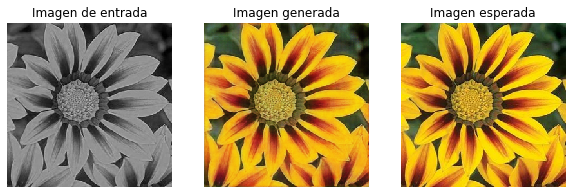

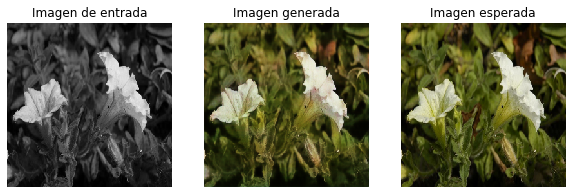

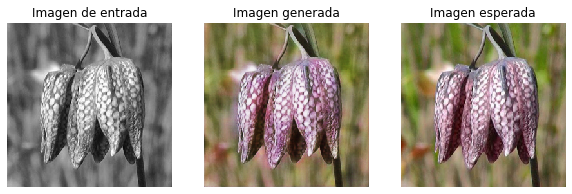

ResourceExhaustedError: ignored

In [21]:
train(train_dataset, 1000)

In [0]:
def test(dataset):

  imgi = 0
  for inp, tar in dataset.shuffle(test_n).take(3):
#       generate_images(generator, inp, tar,  str(imgi) + '_' + str(epoch), display_imgs=True)
      generate_images(generator, inp, tar,  str(imgi), display_imgs=True)
      imgi+=1




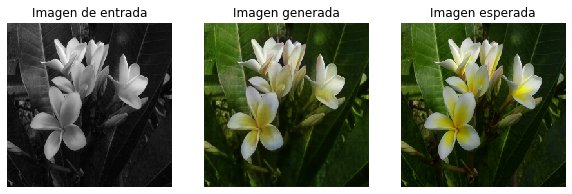

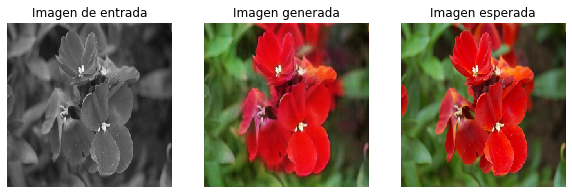

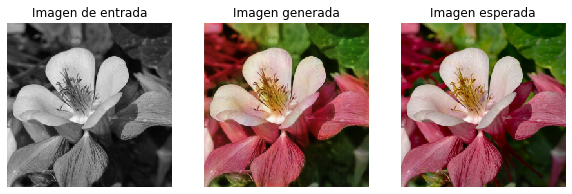

In [25]:
test(test_dataset)